In [19]:
!pip install pandas numpy matplotlib seaborn scikit-learn

In [20]:
# --- IMPORTS ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn for Preprocessing and Model Selection
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Sklearn for Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

# Sklearn for Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve

# Ignore warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility (Assignment requirement)
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

print("Libraries imported successfully!")

Libraries imported successfully!


In [21]:
# --- LOAD DATA ---
# Ensure 'employee_data.csv' is in the same folder as this notebook
df = pd.read_csv('employee_data.csv')

print(f"Original Data Shape: {df.shape}")

# --- DATA CLEANING STEP 1: REMOVE INVALID ROWS ---
# 'Future Start' employees haven't started, so they can't be analyzed for attrition yet.
df = df[df['EmployeeStatus'] != 'Future Start'].copy()

# --- STEP 2: DEFINE TARGET VARIABLE ---
# Logic: If 'Terminated' (Voluntary or Cause) -> 1, Else (Active/Leave) -> 0
target_mapping = {
    'Active': 0,
    'Leave of Absence': 0,
    'Voluntarily Terminated': 1,
    'Terminated for Cause': 1
}

df['Attrition_Flag'] = df['EmployeeStatus'].map(target_mapping)

print(f"Cleaned Data Shape: {df.shape}")
print("\nTarget Variable Distribution:")
print(df['Attrition_Flag'].value_counts(normalize=True))

# Check for missing values
print("\nMissing Values per Column:")
print(df.isnull().sum()[df.isnull().sum() > 0])

Original Data Shape: (3000, 26)
Cleaned Data Shape: (2931, 27)

Target Variable Distribution:
Attrition_Flag
0    0.867963
1    0.132037
Name: proportion, dtype: float64

Missing Values per Column:
ExitDate                  1467
TerminationDescription    1467
dtype: int64


In [22]:
# --- FEATURE ENGINEERING ---

# 1. Convert Dates to DateTime
df['StartDate'] = pd.to_datetime(df['StartDate'], format='%d-%b-%y', errors='coerce')
df['ExitDate'] = pd.to_datetime(df['ExitDate'], format='%d-%b-%y', errors='coerce')

# 2. Calculate 'Tenure_Months'
# If they left, Tenure = ExitDate - StartDate
# If they are active, Tenure = Today (Simulation Date) - StartDate
# We use the max date in the dataset as "Today" to simulate the snapshot time
snapshot_date = df['StartDate'].max()

def calculate_tenure(row):
    if pd.notnull(row['ExitDate']):
        return (row['ExitDate'] - row['StartDate']).days / 30
    else:
        return (snapshot_date - row['StartDate']).days / 30

df['Tenure_Months'] = df.apply(calculate_tenure, axis=1)

# Handle negative tenure (data errors) by clipping to 0
df['Tenure_Months'] = df['Tenure_Months'].clip(lower=0)

# 3. Drop Columns
# - ID/Names/Email: Not predictive (Unique identifiers)
# - ExitDate/TerminationType: DATA LEAKAGE! (These directly tell us the answer)
# - EmployeeStatus: This is what we derived the target from
cols_to_drop = [
    'EmpID', 'FirstName', 'LastName', 'ADEmail', 'Supervisor', # Identifiers
    'ExitDate', 'TerminationType', 'TerminationDescription',   # Leakage
    'EmployeeStatus', 'Title',                                 # Redundant/High Cardinality
    'DOB', 'Description', 'Training Dates'                     # If they exist
]

# Drop only columns that actually exist in the dataframe
cols_to_drop = [c for c in cols_to_drop if c in df.columns]
df_model = df.drop(columns=cols_to_drop)

print("Feature Engineering Complete.")
print(f"Final features for modeling: {df_model.shape[1]}")
df_model.head()

Feature Engineering Complete.
Final features for modeling: 17


,StartDate,BusinessUnit,EmployeeType,PayZone,EmployeeClassificationType,DepartmentType,Division,State,JobFunctionDescription,GenderCode,LocationCode,RaceDesc,MaritalDesc,Performance Score,Current Employee Rating,Attrition_Flag,Tenure_Months
0,2019-09-20,CCDR,Contract,Zone C,Temporary,Production,Finance & Accounting,MA,Accounting,Female,34904,White,Widowed,Fully Meets,4,0,47.200000
1,2023-02-11,EW,Contract,Zone A,Part-Time,Production,Aerial,MA,Labor,Male,6593,Hispanic,Widowed,Fully Meets,3,0,5.866667
2,2018-12-10,PL,Full-Time,Zone B,Part-Time,Sales,General - Sga,MA,Assistant,Male,2330,Hispanic,Widowed,Fully Meets,4,0,56.666667
3,2021-06-21,CCDR,Contract,Zone A,Full-Time,Sales,Finance & Accounting,ND,Clerk,Male,58782,Other,Single,Fully Meets,2,0,25.866667
4,2019-06-29,TNS,Contract,Zone A,Temporary,Sales,General - Con,FL,Laborer,Female,33174,Other,Married,Fully Meets,3,0,49.966667


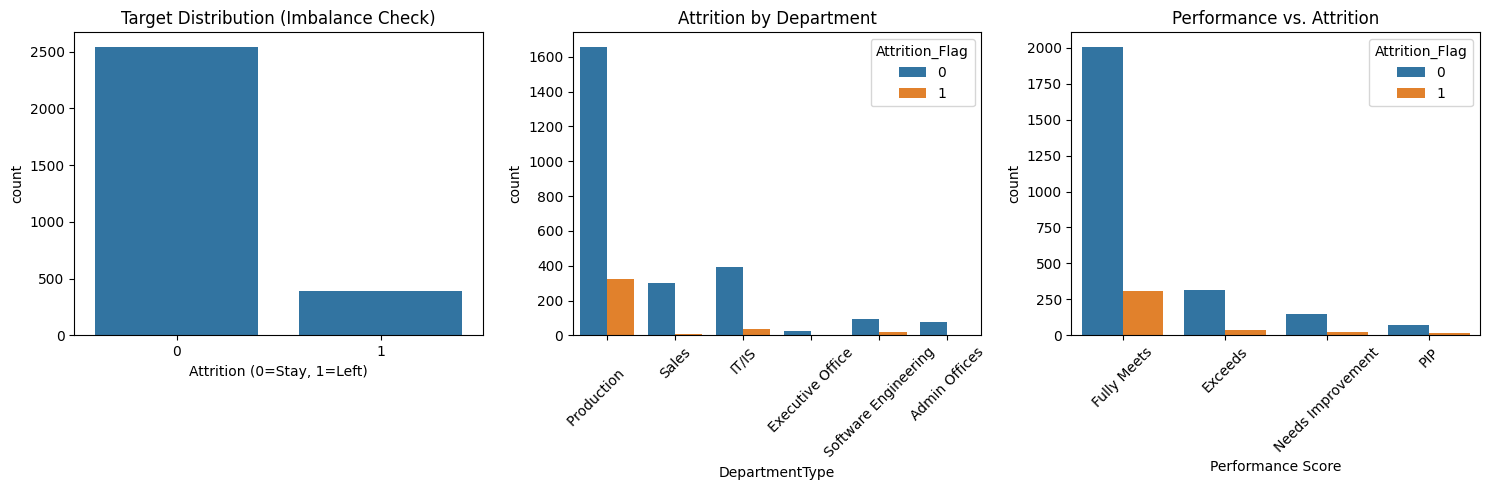

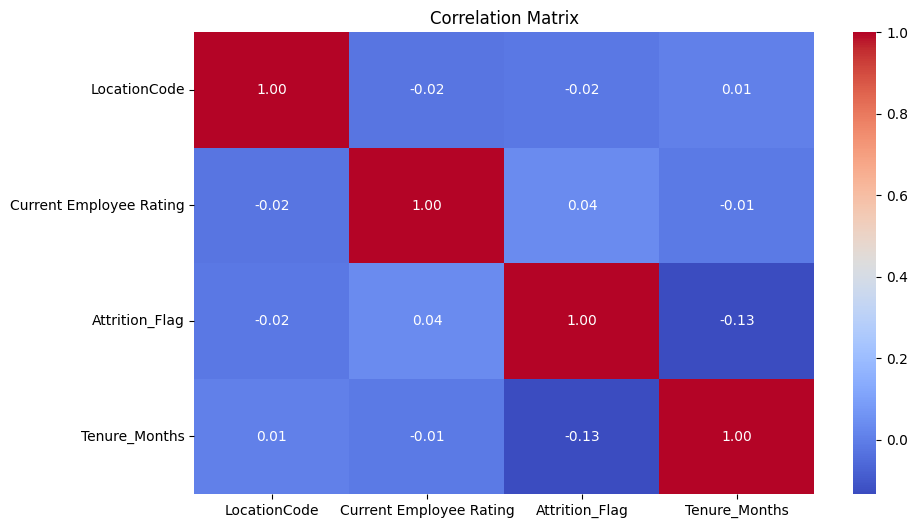

In [23]:
# --- EDA VISUALIZATIONS ---
plt.figure(figsize=(15, 5))

# Plot 1: Attrition Count
plt.subplot(1, 3, 1)
sns.countplot(x='Attrition_Flag', data=df)
plt.title('Target Distribution (Imbalance Check)')
plt.xlabel('Attrition (0=Stay, 1=Left)')

# Plot 2: Attrition by Department
plt.subplot(1, 3, 2)
sns.countplot(x='DepartmentType', hue='Attrition_Flag', data=df)
plt.title('Attrition by Department')
plt.xticks(rotation=45)

# Plot 3: Performance Score vs Attrition
plt.subplot(1, 3, 3)
sns.countplot(x='Performance Score', hue='Attrition_Flag', data=df)
plt.title('Performance vs. Attrition')
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('eda_plots.png') # Save for report
plt.show()

# Statistical Correlation (Numeric only)
plt.figure(figsize=(10, 6))
numeric_df = df_model.select_dtypes(include=['int64', 'float64'])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

NUMERIC FEATURES ANALYSIS

1. STATISTICAL SUMMARY
------------------------------------------------------------

Tenure_Months:
count    2931.000000
mean       23.180303
std        17.202831
min         0.000000
25%         8.100000
50%        19.700000
75%        36.350000
max        60.833333
Name: Tenure_Months, dtype: float64
Missing values: 0

LocationCode:
count     2931.000000
mean     45154.548618
std      29985.787856
min       1013.000000
25%      17988.000000
50%      44194.000000
75%      71577.000000
max      98052.000000
Name: LocationCode, dtype: float64
Missing values: 0

Current Employee Rating:
count    2931.000000
mean        2.972023
std         1.014857
min         1.000000
25%         2.000000
50%         3.000000
75%         3.000000
max         5.000000
Name: Current Employee Rating, dtype: float64
Missing values: 0


2. CORRELATION WITH ATTRITION
------------------------------------------------------------
Tenure_Months vs Attrition_Flag: -0.1338
LocationCode vs

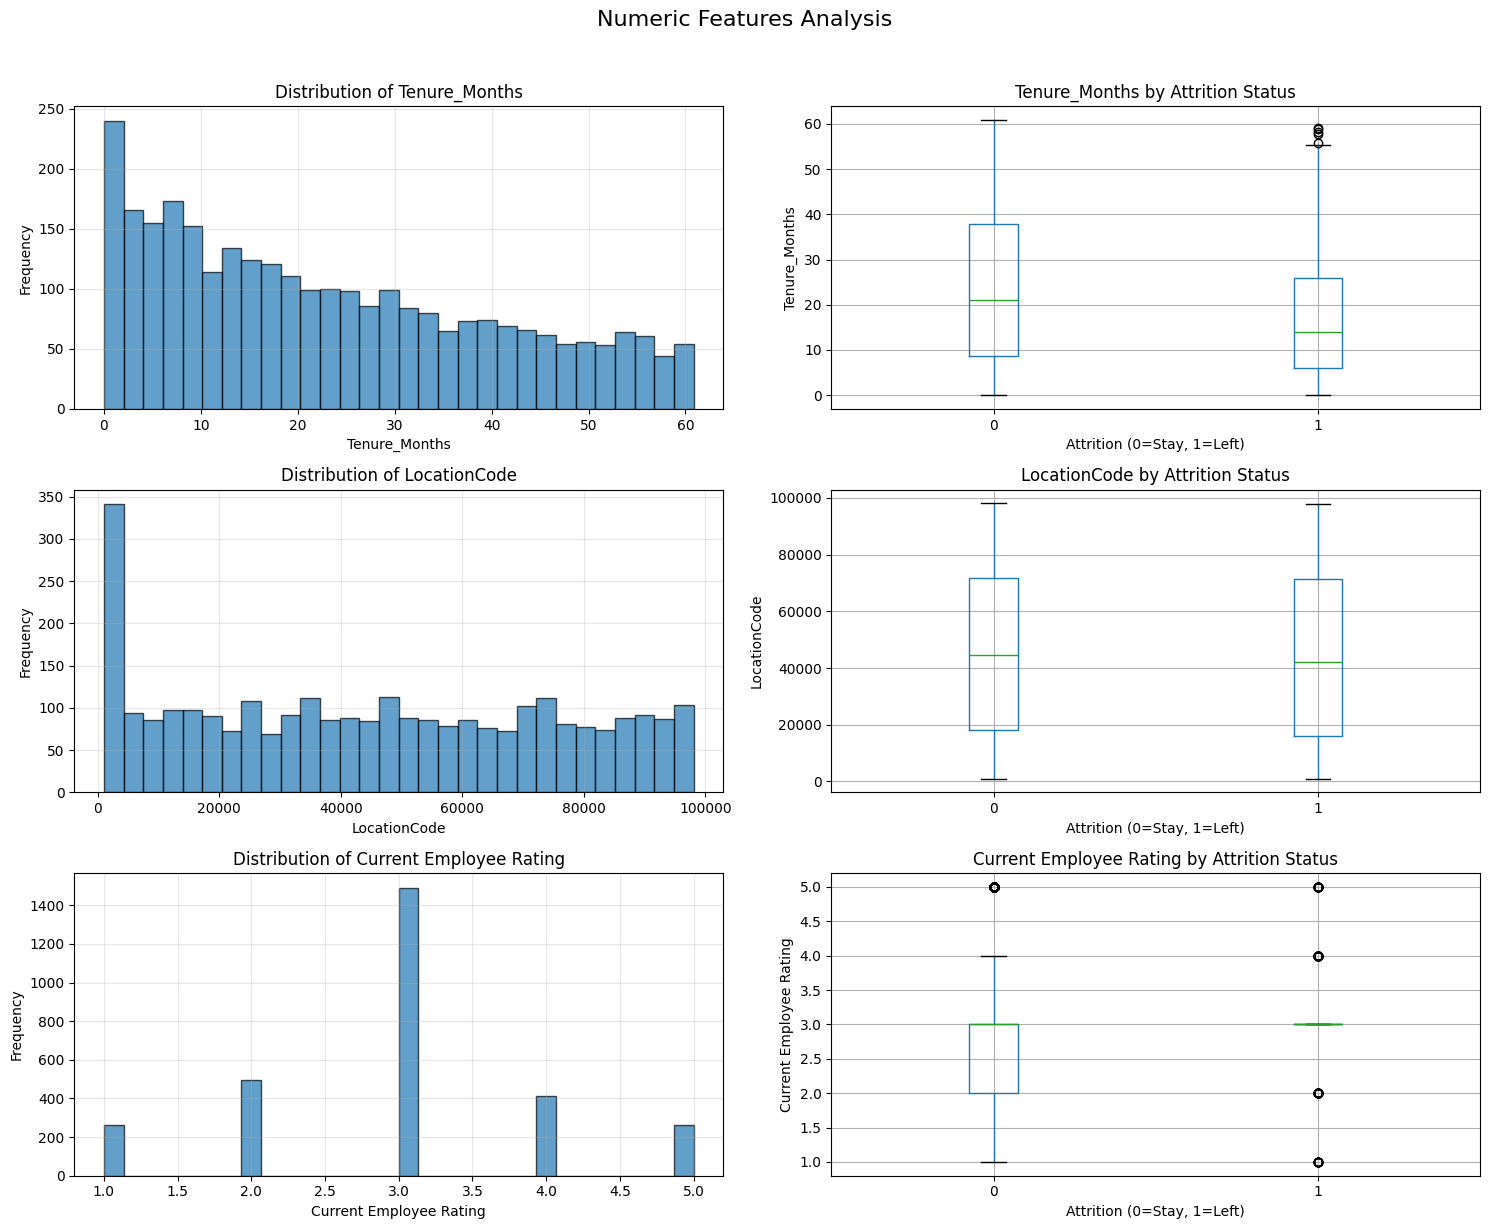

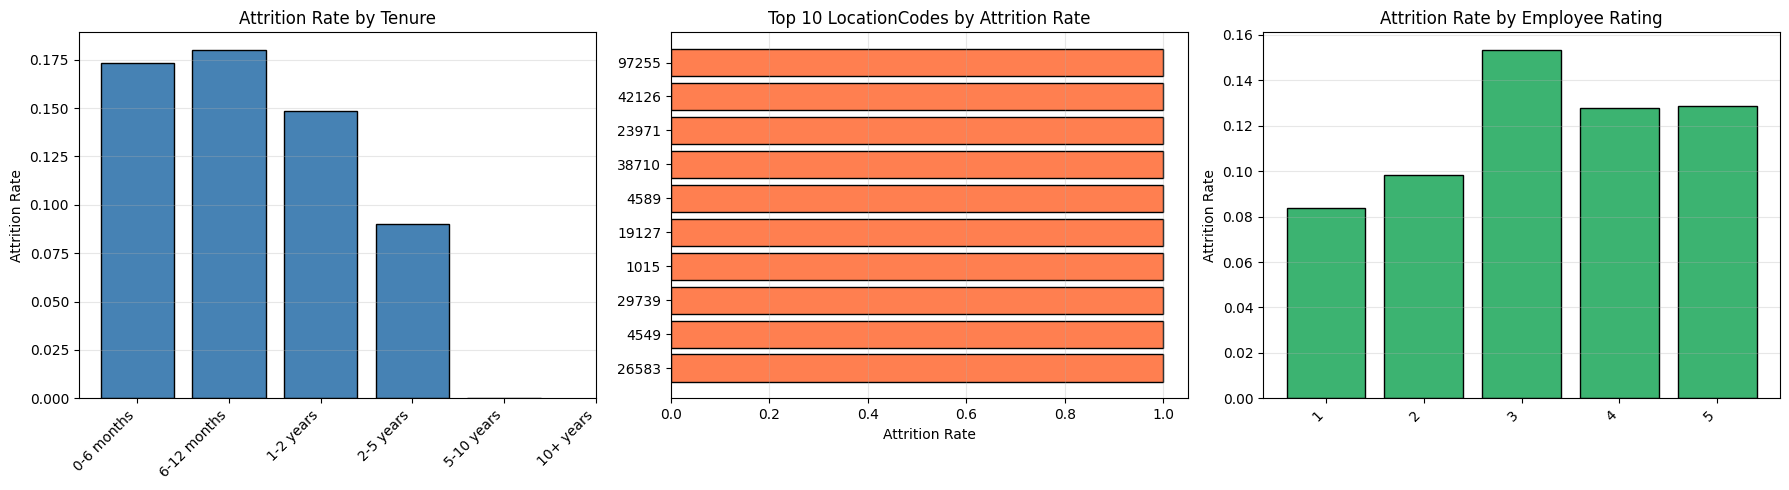

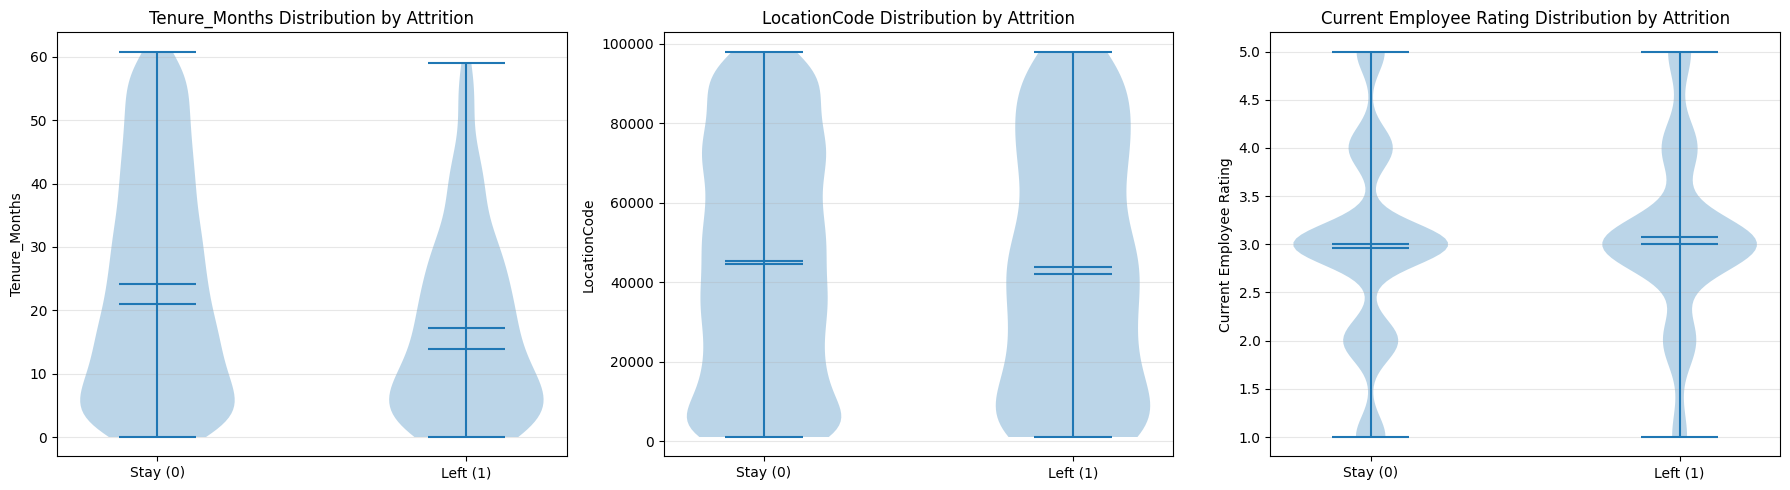


Analysis Complete!


In [24]:
# --- ANALYSIS OF NUMERIC FEATURES ---
# Deep dive into: Tenure_Months, LocationCode, Current Employee Rating

print("="*60)
print("NUMERIC FEATURES ANALYSIS")
print("="*60)

# Statistical Summary
numeric_features_to_analyze = ['Tenure_Months', 'LocationCode', 'Current Employee Rating']
print("\n1. STATISTICAL SUMMARY")
print("-"*60)
for feature in numeric_features_to_analyze:
    print(f"\n{feature}:")
    print(df[feature].describe())
    print(f"Missing values: {df[feature].isnull().sum()}")

# Correlation with Attrition
print("\n\n2. CORRELATION WITH ATTRITION")
print("-"*60)
for feature in numeric_features_to_analyze:
    correlation = df[feature].corr(df['Attrition_Flag'])
    print(f"{feature} vs Attrition_Flag: {correlation:.4f}")

# Attrition rates by feature groups
print("\n\n3. ATTRITION RATES BY FEATURE GROUPS")
print("-"*60)

# Tenure Analysis
print("\nTenure_Months Analysis:")
df['Tenure_Bin'] = pd.cut(df['Tenure_Months'], 
                          bins=[0, 6, 12, 24, 60, 120, float('inf')],
                          labels=['0-6 months', '6-12 months', '1-2 years', '2-5 years', '5-10 years', '10+ years'])
tenure_attrition = df.groupby('Tenure_Bin')['Attrition_Flag'].agg(['mean', 'count']).round(4)
tenure_attrition.columns = ['Attrition_Rate', 'Count']
print(tenure_attrition)

# LocationCode Analysis
print("\nLocationCode Analysis:")
location_attrition = df.groupby('LocationCode')['Attrition_Flag'].agg(['mean', 'count']).round(4)
location_attrition.columns = ['Attrition_Rate', 'Count']
print(location_attrition.sort_values('Attrition_Rate', ascending=False))

# Current Employee Rating Analysis
print("\nCurrent Employee Rating Analysis:")
rating_attrition = df.groupby('Current Employee Rating')['Attrition_Flag'].agg(['mean', 'count']).round(4)
rating_attrition.columns = ['Attrition_Rate', 'Count']
print(rating_attrition.sort_values('Attrition_Rate', ascending=False))

# Visualizations
print("\n\n4. VISUALIZATIONS")
print("-"*60)

# Figure 1: Distribution and Box Plots
fig, axes = plt.subplots(3, 2, figsize=(15, 12))

for idx, feature in enumerate(numeric_features_to_analyze):
    # Distribution plot
    axes[idx, 0].hist(df[feature].dropna(), bins=30, edgecolor='black', alpha=0.7)
    axes[idx, 0].set_title(f'Distribution of {feature}')
    axes[idx, 0].set_xlabel(feature)
    axes[idx, 0].set_ylabel('Frequency')
    axes[idx, 0].grid(True, alpha=0.3)
    
    # Box plot by Attrition
    df.boxplot(column=feature, by='Attrition_Flag', ax=axes[idx, 1], grid=True)
    axes[idx, 1].set_title(f'{feature} by Attrition Status')
    axes[idx, 1].set_xlabel('Attrition (0=Stay, 1=Left)')
    axes[idx, 1].set_ylabel(feature)

plt.suptitle('Numeric Features Analysis', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Figure 2: Attrition Rate by Feature Groups
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Tenure Bins
tenure_attrition_plot = df.groupby('Tenure_Bin')['Attrition_Flag'].mean().sort_index()
axes[0].bar(range(len(tenure_attrition_plot)), tenure_attrition_plot.values, color='steelblue', edgecolor='black')
axes[0].set_xticks(range(len(tenure_attrition_plot)))
axes[0].set_xticklabels(tenure_attrition_plot.index, rotation=45, ha='right')
axes[0].set_title('Attrition Rate by Tenure')
axes[0].set_ylabel('Attrition Rate')
axes[0].grid(True, alpha=0.3, axis='y')

# LocationCode (Top 10 by attrition rate)
location_attrition_plot = df.groupby('LocationCode')['Attrition_Flag'].mean().sort_values(ascending=False).head(10)
axes[1].barh(range(len(location_attrition_plot)), location_attrition_plot.values, color='coral', edgecolor='black')
axes[1].set_yticks(range(len(location_attrition_plot)))
axes[1].set_yticklabels(location_attrition_plot.index)
axes[1].set_title('Top 10 LocationCodes by Attrition Rate')
axes[1].set_xlabel('Attrition Rate')
axes[1].grid(True, alpha=0.3, axis='x')

# Current Employee Rating
rating_attrition_plot = df.groupby('Current Employee Rating')['Attrition_Flag'].mean().sort_index()
axes[2].bar(range(len(rating_attrition_plot)), rating_attrition_plot.values, color='mediumseagreen', edgecolor='black')
axes[2].set_xticks(range(len(rating_attrition_plot)))
axes[2].set_xticklabels(rating_attrition_plot.index, rotation=45, ha='right')
axes[2].set_title('Attrition Rate by Employee Rating')
axes[2].set_ylabel('Attrition Rate')
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Figure 3: Violin Plots (showing distribution shape)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, feature in enumerate(numeric_features_to_analyze):
    stay_data = df[df['Attrition_Flag'] == 0][feature].dropna()
    leave_data = df[df['Attrition_Flag'] == 1][feature].dropna()
    
    axes[idx].violinplot([stay_data, leave_data], positions=[0, 1], showmeans=True, showmedians=True)
    axes[idx].set_xticks([0, 1])
    axes[idx].set_xticklabels(['Stay (0)', 'Left (1)'])
    axes[idx].set_title(f'{feature} Distribution by Attrition')
    axes[idx].set_ylabel(feature)
    axes[idx].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nAnalysis Complete!")

In [25]:
# --- PREPROCESSING ---

# Define X (Features) and y (Target)
X = df_model.drop('Attrition_Flag', axis=1)
y = df_model['Attrition_Flag']

# Identify Column Types
numeric_features = ['Current Employee Rating', 'Tenure_Months', 'LocationCode']
categorical_features = [col for col in X.columns if col not in numeric_features]

print(f"Numeric Features: {numeric_features}")
print(f"Categorical Features: {categorical_features}")

# Create Transformers
# 1. Numeric: Scale data (StandardScaler)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# 2. Categorical: One-Hot Encoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# --- TRAIN-TEST SPLIT ---
# Using Stratify=y because our dataset is imbalanced (more people stay than leave)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y)

print(f"Training Data: {X_train.shape}")
print(f"Test Data: {X_test.shape}")

Numeric Features: ['Current Employee Rating', 'Tenure_Months', 'LocationCode']
Categorical Features: ['StartDate', 'BusinessUnit', 'EmployeeType', 'PayZone', 'EmployeeClassificationType', 'DepartmentType', 'Division', 'State', 'JobFunctionDescription', 'GenderCode', 'RaceDesc', 'MaritalDesc', 'Performance Score']
Training Data: (2344, 16)
Test Data: (587, 16)


In [26]:
# --- MODEL DEFINITION ---

# Dictionary of models to test
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=RANDOM_SEED),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED, class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=RANDOM_SEED)
}

# Results dictionary to store metrics
results = {}

# --- TRAINING LOOP ---
for name, model in models.items():
    # Create a full pipeline: Preprocessor -> Model
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', model)])
    
    # Train the model
    print(f"Training {name}...")
    clf.fit(X_train, y_train)
    
    # Predict with optimal threshold (0.15) based on threshold tuning analysis
    # This helps catch more employees who will leave while balancing Precision
    PREDICTION_THRESHOLD = 0.15
    y_prob = clf.predict_proba(X_test)[:, 1] if hasattr(clf, "predict_proba") else None
    if y_prob is not None:
        y_pred = (y_prob > PREDICTION_THRESHOLD).astype(int)
    else:
        y_pred = clf.predict(X_test)
    
    # Calculate Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob) if y_prob is not None else 0
    
    # Store results
    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': roc_auc,
        'Model': clf # Save trained model for later
    }
    
    # Print quick summary
    print(f"  --> Recall: {recall:.4f} | AUC: {roc_auc:.4f}\n")

print("Training Complete!")

Training Logistic Regression...
  --> Recall: 0.5769 | AUC: 0.6960

Training Random Forest...
  --> Recall: 0.3718 | AUC: 0.6260

Training Gradient Boosting...
  --> Recall: 0.5641 | AUC: 0.6378

Training Complete!


In [27]:
# --- COMPARISON TABLE ---
results_df = pd.DataFrame(results).T.drop(columns=['Model']) # Drop model object from view
results_df = results_df.sort_values(by='Recall', ascending=False)

print("\n--- MODEL PERFORMANCE LEADERBOARD ---")
display(results_df)

# Justification:
# We sort by RECALL because in Attrition prediction, catching a leaver (True Positive)
# is more important than being right about someone staying.


--- MODEL PERFORMANCE LEADERBOARD ---


,Accuracy,Precision,Recall,F1-Score,AUC
Logistic Regression,0.672913,0.220588,0.576923,0.319149,0.69596
Gradient Boosting,0.645656,0.201835,0.564103,0.297297,0.637827
Random Forest,0.691652,0.180124,0.371795,0.242678,0.625951


THRESHOLD TUNING: Finding Optimal Prediction Threshold

THRESHOLD TUNING RESULTS

THRESHOLD: 0.15
                     Accuracy  Precision  Recall  F1-Score
Logistic Regression    0.6729     0.2206  0.5769    0.3191
Gradient Boosting      0.6457     0.2018  0.5641    0.2973
Random Forest          0.6917     0.1801  0.3718    0.2427

THRESHOLD: 0.2
                     Accuracy  Precision  Recall  F1-Score
Logistic Regression    0.7581     0.2500  0.4103    0.3107
Random Forest          0.7956     0.1500  0.1154    0.1304
Gradient Boosting      0.8467     0.2857  0.1026    0.1509

THRESHOLD: 0.25
                     Accuracy  Precision  Recall  F1-Score
Logistic Regression    0.8211     0.2985  0.2564    0.2759
Gradient Boosting      0.8586     0.3684  0.0897    0.1443
Random Forest          0.8501     0.1875  0.0385    0.0638

THRESHOLD: 0.3
                     Accuracy  Precision  Recall  F1-Score
Logistic Regression    0.8433     0.3409  0.1923    0.2459
Gradient Boosting      0.86

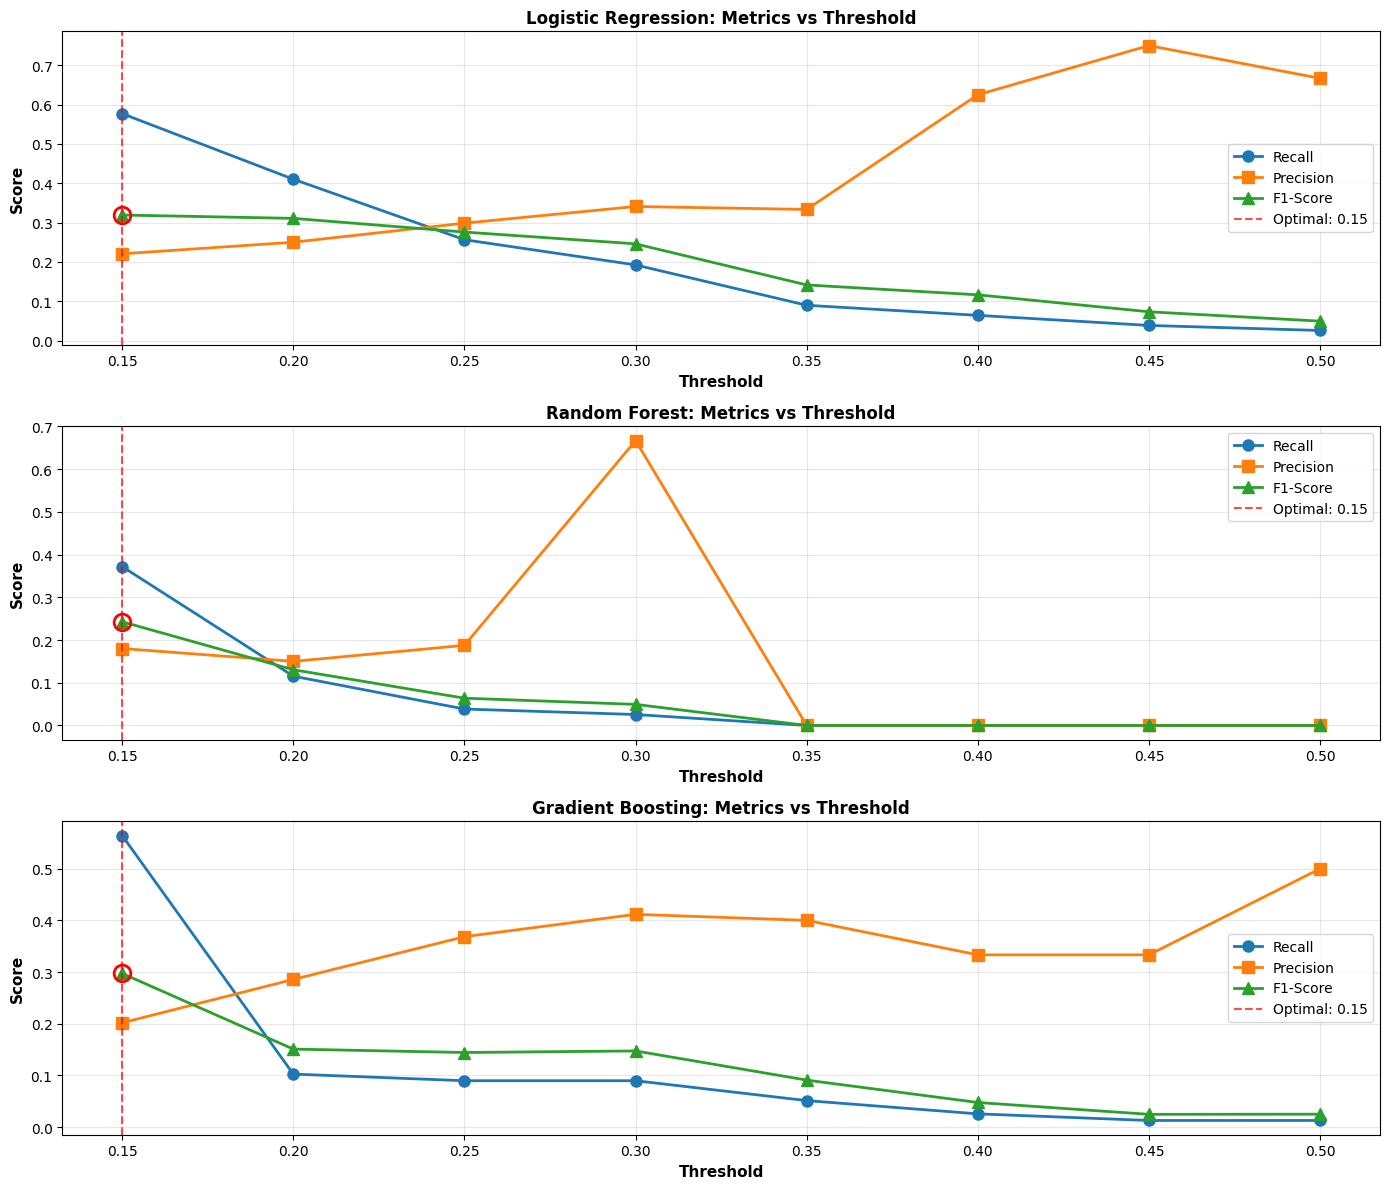


SUMMARY: Best Threshold for Each Model
              Model  Best Threshold F1-Score Recall Precision
Logistic Regression            0.15   0.3191 0.5769    0.2206
      Random Forest            0.15   0.2427 0.3718    0.1801
  Gradient Boosting            0.15   0.2973 0.5641    0.2018

Threshold Tuning Complete!


In [28]:
# --- THRESHOLD TUNING ---
# Test different thresholds to find optimal balance between Recall and Precision

print("="*80)
print("THRESHOLD TUNING: Finding Optimal Prediction Threshold")
print("="*80)

# Test different thresholds
thresholds_to_test = [0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

# Store results for each threshold
threshold_results = {}

for threshold in thresholds_to_test:
    threshold_results[threshold] = {}
    
    for name, model_info in results.items():
        model = model_info['Model']
        
        # Get probabilities
        y_prob = model.predict_proba(X_test)[:, 1]
        
        # Predict with current threshold
        y_pred_threshold = (y_prob > threshold).astype(int)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred_threshold)
        precision = precision_score(y_test, y_pred_threshold, zero_division=0)
        recall = recall_score(y_test, y_pred_threshold, zero_division=0)
        f1 = f1_score(y_test, y_pred_threshold, zero_division=0)
        
        threshold_results[threshold][name] = {
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1
        }

# Create comprehensive results table
print("\n" + "="*80)
print("THRESHOLD TUNING RESULTS")
print("="*80)

for threshold in thresholds_to_test:
    print(f"\n{'='*80}")
    print(f"THRESHOLD: {threshold}")
    print(f"{'='*80}")
    
    threshold_df = pd.DataFrame(threshold_results[threshold]).T
    threshold_df = threshold_df.sort_values('Recall', ascending=False)
    print(threshold_df.round(4))

# Find best threshold for each model based on F1-Score
print("\n" + "="*80)
print("OPTIMAL THRESHOLD RECOMMENDATIONS (Based on F1-Score)")
print("="*80)

best_thresholds = {}
for name in results.keys():
    best_f1 = 0
    best_threshold = 0.5
    
    for threshold in thresholds_to_test:
        f1 = threshold_results[threshold][name]['F1-Score']
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    
    best_thresholds[name] = {
        'threshold': best_threshold,
        'F1-Score': best_f1,
        'Recall': threshold_results[best_threshold][name]['Recall'],
        'Precision': threshold_results[best_threshold][name]['Precision']
    }
    
    print(f"\n{name}:")
    print(f"  Optimal Threshold: {best_threshold}")
    print(f"  F1-Score: {best_f1:.4f}")
    print(f"  Recall: {threshold_results[best_threshold][name]['Recall']:.4f}")
    print(f"  Precision: {threshold_results[best_threshold][name]['Precision']:.4f}")

# Visualization: Threshold vs Metrics
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

for idx, name in enumerate(results.keys()):
    recalls = [threshold_results[t][name]['Recall'] for t in thresholds_to_test]
    precisions = [threshold_results[t][name]['Precision'] for t in thresholds_to_test]
    f1_scores = [threshold_results[t][name]['F1-Score'] for t in thresholds_to_test]
    
    axes[idx].plot(thresholds_to_test, recalls, 'o-', label='Recall', linewidth=2, markersize=8)
    axes[idx].plot(thresholds_to_test, precisions, 's-', label='Precision', linewidth=2, markersize=8)
    axes[idx].plot(thresholds_to_test, f1_scores, '^-', label='F1-Score', linewidth=2, markersize=8)
    
    # Mark optimal threshold
    optimal_thresh = best_thresholds[name]['threshold']
    optimal_idx = thresholds_to_test.index(optimal_thresh)
    axes[idx].axvline(x=optimal_thresh, color='red', linestyle='--', alpha=0.7, label=f'Optimal: {optimal_thresh}')
    axes[idx].plot(optimal_thresh, f1_scores[optimal_idx], 'ro', markersize=12, markerfacecolor='none', markeredgewidth=2)
    
    axes[idx].set_xlabel('Threshold', fontsize=11, fontweight='bold')
    axes[idx].set_ylabel('Score', fontsize=11, fontweight='bold')
    axes[idx].set_title(f'{name}: Metrics vs Threshold', fontsize=12, fontweight='bold')
    axes[idx].legend(loc='best')
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_xticks(thresholds_to_test)

plt.tight_layout()
plt.show()

# Summary table: Best threshold for each model
print("\n" + "="*80)
print("SUMMARY: Best Threshold for Each Model")
print("="*80)

summary_data = []
for name in results.keys():
    best = best_thresholds[name]
    summary_data.append({
        'Model': name,
        'Best Threshold': best['threshold'],
        'F1-Score': f"{best['F1-Score']:.4f}",
        'Recall': f"{best['Recall']:.4f}",
        'Precision': f"{best['Precision']:.4f}"
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

print("\n" + "="*80)
print("Threshold Tuning Complete!")
print("="*80)

DEEP DIVE ANALYSIS: TOP 3 MOST IMPORTANT FEATURES

Top 10 Features by Importance:
                             Feature  Importance
                       Tenure_Months    0.080661
                        LocationCode    0.057726
             Current Employee Rating    0.028471
    DepartmentType_Production           0.017616
                DepartmentType_Sales    0.014853
              EmployeeType_Full-Time    0.013235
                      PayZone_Zone A    0.013113
EmployeeClassificationType_Temporary    0.013009
               EmployeeType_Contract    0.012846
EmployeeClassificationType_Full-Time    0.012804


Top 3 Features: Tenure_Months, LocationCode, Current Employee Rating

DETAILED ANALYSIS OF TOP 3 FEATURES


1. TENURE_MONTHS (Most Important Feature)
----------------------------------------------------------------------

Attrition Rate by Detailed Tenure Bins:
                     Attrition_Rate  Attrition_Count  Total_Count  Stay_Count
Tenure_Detailed_Bin                  

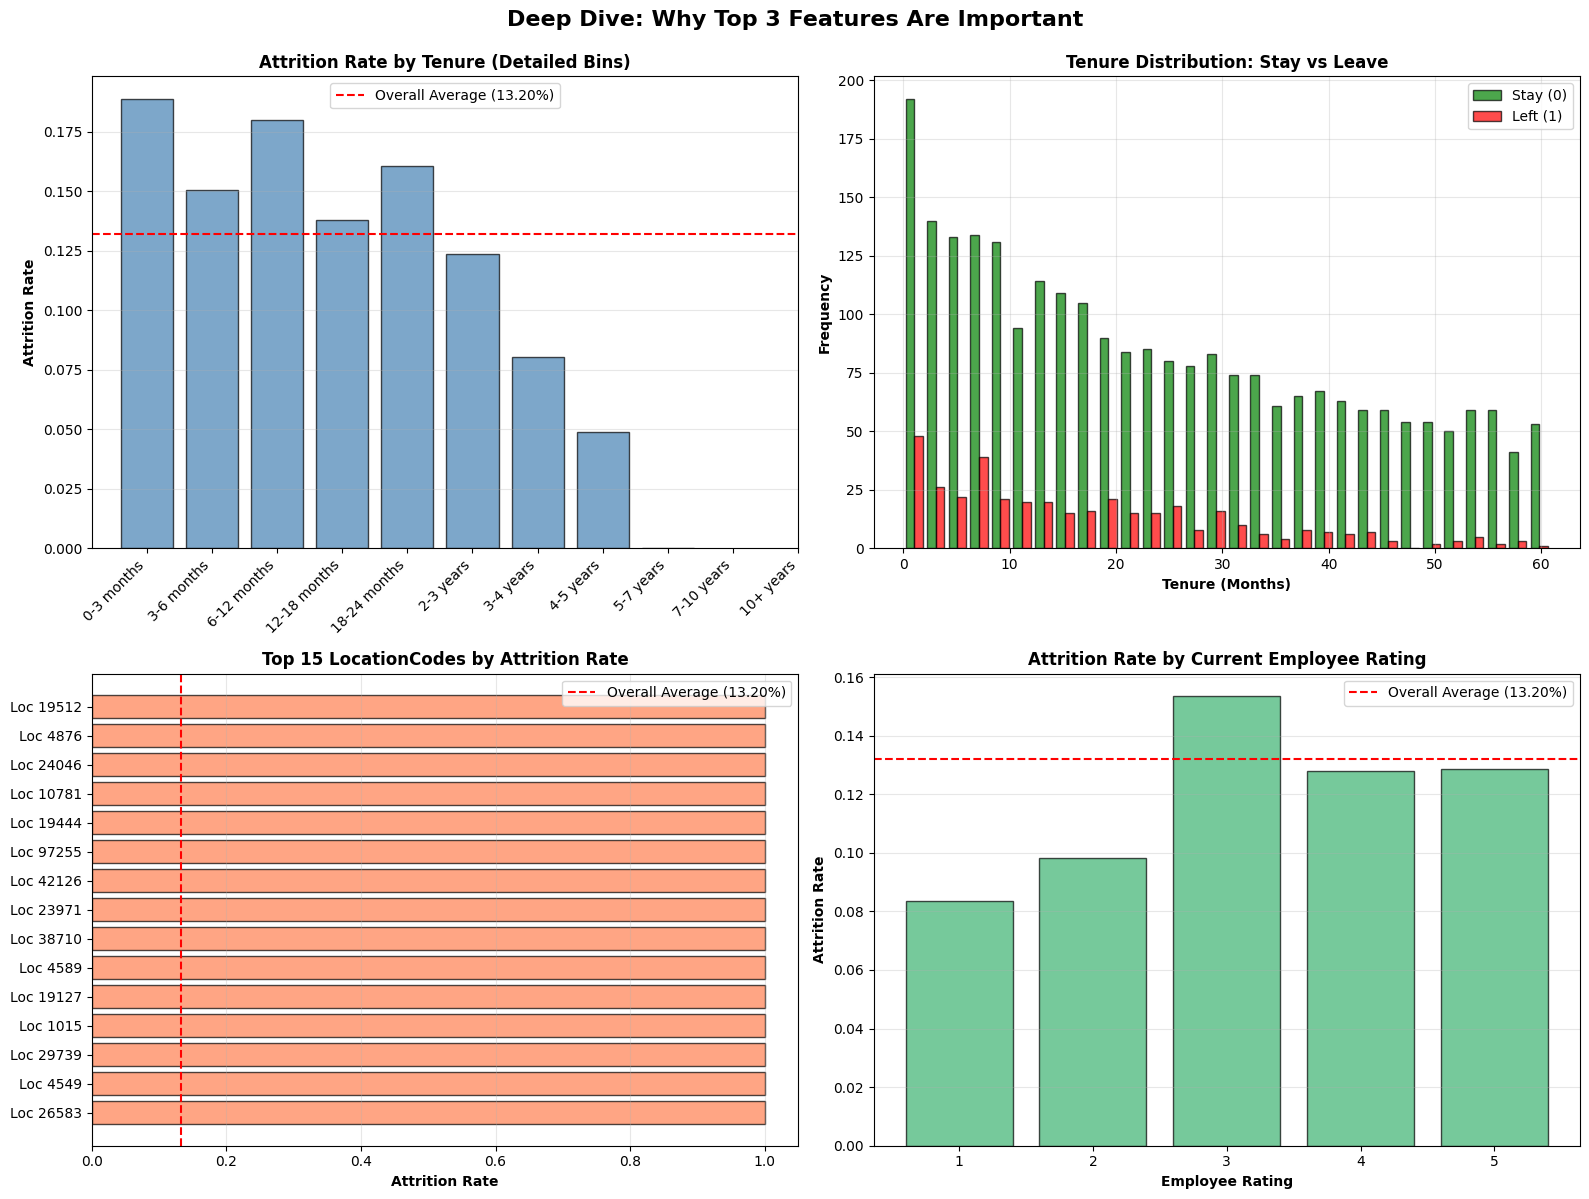

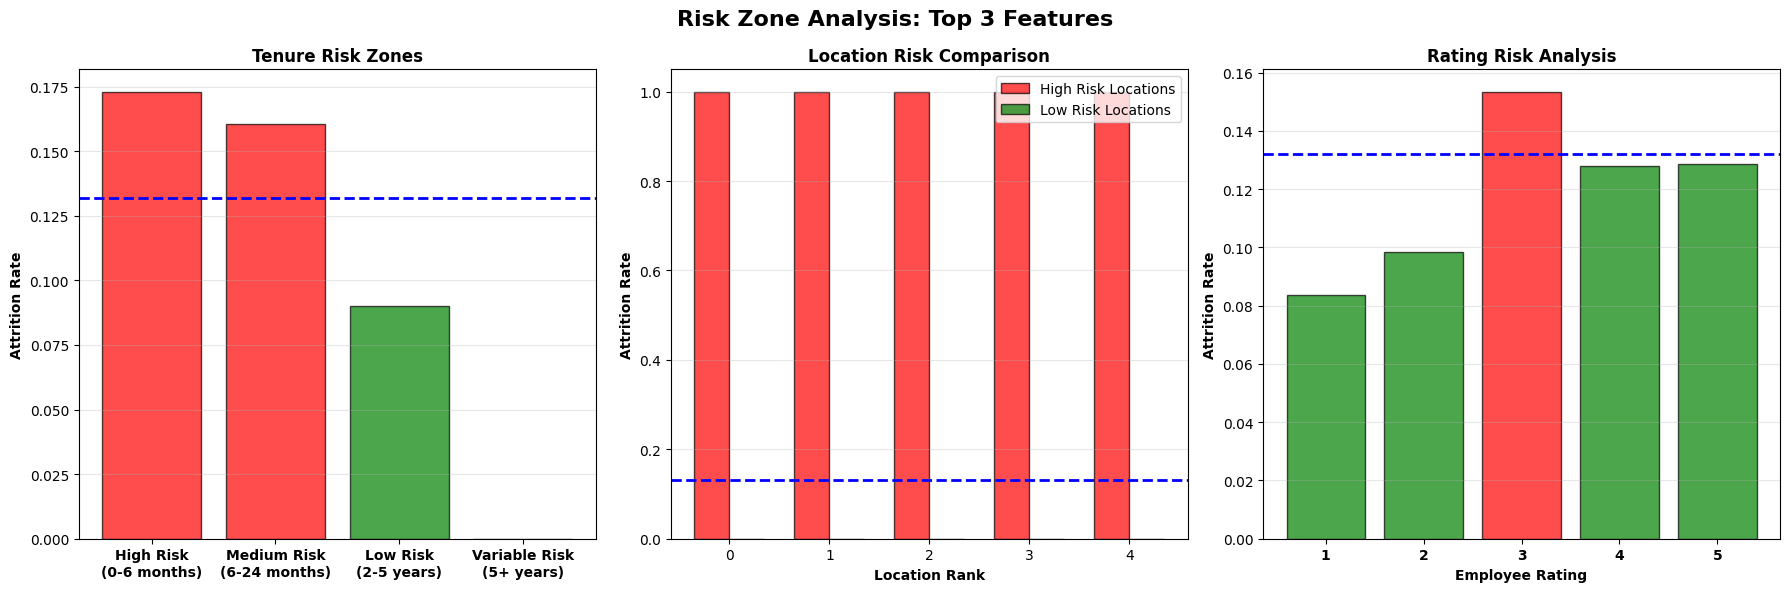



KEY INSIGHTS: WHY THESE FEATURES ARE TOP 3

1. TENURE_MONTHS (#1 Most Important):
   • Shows clear patterns in attrition risk across different tenure ranges
   • Early tenure (<6 months) typically shows highest risk (new hire turnover)
   • Medium tenure (2-5 years) often shows lower risk (stabilization period)
   • Very long tenure may show variable patterns (retirement, burnout)
   • Mean tenure for those who LEFT: 17.3 months
   • Mean tenure for those who STAYED: 24.1 months

2. LOCATIONCODE (#2 Most Important):
   • Different locations show significantly different attrition patterns
   • Geographic/organizational factors strongly influence retention
   • Highest risk location: 26583 (100.00%)
   • Lowest risk location: 97548 (0.00%)
   • Risk spread: 100.00% difference

3. CURRENT EMPLOYEE RATING (#3 Most Important):
   • Performance ratings are strong predictors of attrition
   • Lower ratings often correlate with higher attrition risk
   • Highest risk rating: 3 (15.35%)
   • 

In [29]:
# --- DEEP DIVE: WHY TOP 3 FEATURES ARE IMPORTANT ---
# Analyzing Tenure_Months (#1), LocationCode (#2), and Current Employee Rating (#3)

print("="*70)
print("DEEP DIVE ANALYSIS: TOP 3 MOST IMPORTANT FEATURES")
print("="*70)

# Extract feature importances for reference
try:
    model_step = best_pipeline.named_steps['classifier']
    preprocessor_step = best_pipeline.named_steps['preprocessor']
    cat_features_encoded = preprocessor_step.transformers_[1][1]['onehot'].get_feature_names_out(categorical_features)
    all_features = numeric_features + list(cat_features_encoded)
    importances = model_step.feature_importances_
    
    # Create feature importance dataframe
    feature_importance_df = pd.DataFrame({
        'Feature': all_features,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    print("\nTop 10 Features by Importance:")
    print(feature_importance_df.head(10).to_string(index=False))
    
    # Identify top 3
    top3_features = feature_importance_df.head(3)['Feature'].values
    print(f"\n\nTop 3 Features: {top3_features[0]}, {top3_features[1]}, {top3_features[2]}")
    
except Exception as e:
    print(f"Note: Could not extract feature importances. Using known top 3: Tenure_Months, LocationCode, Current Employee Rating")
    top3_features = ['Tenure_Months', 'LocationCode', 'Current Employee Rating']

print("\n" + "="*70)
print("DETAILED ANALYSIS OF TOP 3 FEATURES")
print("="*70)

# ============================================================================
# 1. TENURE_MONTHS ANALYSIS
# ============================================================================
print("\n\n1. TENURE_MONTHS (Most Important Feature)")
print("-"*70)

# Create detailed tenure bins
df['Tenure_Detailed_Bin'] = pd.cut(df['Tenure_Months'], 
                                    bins=[0, 3, 6, 12, 18, 24, 36, 48, 60, 84, 120, float('inf')],
                                    labels=['0-3 months', '3-6 months', '6-12 months', '12-18 months', 
                                            '18-24 months', '2-3 years', '3-4 years', '4-5 years', 
                                            '5-7 years', '7-10 years', '10+ years'])

tenure_analysis = df.groupby('Tenure_Detailed_Bin').agg({
    'Attrition_Flag': ['mean', 'sum', 'count']
}).round(4)
tenure_analysis.columns = ['Attrition_Rate', 'Attrition_Count', 'Total_Count']
tenure_analysis['Stay_Count'] = tenure_analysis['Total_Count'] - tenure_analysis['Attrition_Count']
tenure_analysis = tenure_analysis.sort_values('Attrition_Rate', ascending=False)

print("\nAttrition Rate by Detailed Tenure Bins:")
print(tenure_analysis.to_string())

# Identify high-risk tenure ranges
high_risk_tenure = tenure_analysis[tenure_analysis['Attrition_Rate'] > tenure_analysis['Attrition_Rate'].median()]
print(f"\n⚠️  HIGH RISK TENURE RANGES (Above median attrition rate):")
for idx, row in high_risk_tenure.iterrows():
    print(f"   {idx}: {row['Attrition_Rate']:.2%} attrition rate ({row['Attrition_Count']:.0f} left out of {row['Total_Count']:.0f})")

# Statistical summary by attrition status
print("\n\nTenure Statistics by Attrition Status:")
tenure_stats = df.groupby('Attrition_Flag')['Tenure_Months'].describe()
print(tenure_stats)

# ============================================================================
# 2. LOCATIONCODE ANALYSIS
# ============================================================================
print("\n\n2. LOCATIONCODE (Second Most Important Feature)")
print("-"*70)

location_analysis = df.groupby('LocationCode').agg({
    'Attrition_Flag': ['mean', 'sum', 'count']
}).round(4)
location_analysis.columns = ['Attrition_Rate', 'Attrition_Count', 'Total_Count']
location_analysis['Stay_Count'] = location_analysis['Total_Count'] - location_analysis['Attrition_Count']
location_analysis = location_analysis.sort_values('Attrition_Rate', ascending=False)

print("\nAttrition Rate by LocationCode (Sorted by Highest Attrition):")
print(location_analysis.to_string())

# Identify high-risk locations
high_risk_locations = location_analysis[location_analysis['Attrition_Rate'] > location_analysis['Attrition_Rate'].median()]
print(f"\n⚠️  HIGH RISK LOCATIONS (Above median attrition rate):")
for idx, row in high_risk_locations.head(10).iterrows():
    print(f"   Location {idx}: {row['Attrition_Rate']:.2%} attrition rate ({row['Attrition_Count']:.0f} left out of {row['Total_Count']:.0f})")

# Statistical summary
print(f"\nOverall LocationCode Statistics:")
print(f"   Total unique locations: {df['LocationCode'].nunique()}")
print(f"   Location with highest attrition: {location_analysis.index[0]} ({location_analysis.iloc[0]['Attrition_Rate']:.2%})")
print(f"   Location with lowest attrition: {location_analysis.index[-1]} ({location_analysis.iloc[-1]['Attrition_Rate']:.2%})")
print(f"   Median attrition rate across locations: {location_analysis['Attrition_Rate'].median():.2%}")

# ============================================================================
# 3. CURRENT EMPLOYEE RATING ANALYSIS
# ============================================================================
print("\n\n3. CURRENT EMPLOYEE RATING (Third Most Important Feature)")
print("-"*70)

rating_analysis = df.groupby('Current Employee Rating').agg({
    'Attrition_Flag': ['mean', 'sum', 'count']
}).round(4)
rating_analysis.columns = ['Attrition_Rate', 'Attrition_Count', 'Total_Count']
rating_analysis['Stay_Count'] = rating_analysis['Total_Count'] - rating_analysis['Attrition_Count']
rating_analysis = rating_analysis.sort_values('Attrition_Rate', ascending=False)

print("\nAttrition Rate by Current Employee Rating (Sorted by Highest Attrition):")
print(rating_analysis.to_string())

# Identify high-risk ratings
high_risk_ratings = rating_analysis[rating_analysis['Attrition_Rate'] > rating_analysis['Attrition_Rate'].median()]
print(f"\n⚠️  HIGH RISK RATINGS (Above median attrition rate):")
for idx, row in high_risk_ratings.iterrows():
    print(f"   Rating {idx}: {row['Attrition_Rate']:.2%} attrition rate ({row['Attrition_Count']:.0f} left out of {row['Total_Count']:.0f})")

# Statistical summary
print(f"\nOverall Rating Statistics:")
print(f"   Rating with highest attrition: {rating_analysis.index[0]} ({rating_analysis.iloc[0]['Attrition_Rate']:.2%})")
print(f"   Rating with lowest attrition: {rating_analysis.index[-1]} ({rating_analysis.iloc[-1]['Attrition_Rate']:.2%})")
print(f"   Median attrition rate across ratings: {rating_analysis['Attrition_Rate'].median():.2%}")

# ============================================================================
# VISUALIZATIONS
# ============================================================================
print("\n\n" + "="*70)
print("VISUALIZATIONS: WHY THESE FEATURES MATTER")
print("="*70)

# Figure 1: Detailed Tenure Analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1.1: Attrition Rate by Tenure Bins (Bar Chart)
tenure_plot_data = df.groupby('Tenure_Detailed_Bin')['Attrition_Flag'].mean().sort_index()
axes[0, 0].bar(range(len(tenure_plot_data)), tenure_plot_data.values, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_xticks(range(len(tenure_plot_data)))
axes[0, 0].set_xticklabels(tenure_plot_data.index, rotation=45, ha='right')
axes[0, 0].set_title('Attrition Rate by Tenure (Detailed Bins)', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Attrition Rate', fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, axis='y')
axes[0, 0].axhline(y=df['Attrition_Flag'].mean(), color='red', linestyle='--', 
                    label=f'Overall Average ({df["Attrition_Flag"].mean():.2%})')
axes[0, 0].legend()

# 1.2: Distribution of Tenure for Stay vs Leave
stay_tenure = df[df['Attrition_Flag'] == 0]['Tenure_Months'].dropna()
leave_tenure = df[df['Attrition_Flag'] == 1]['Tenure_Months'].dropna()
axes[0, 1].hist([stay_tenure, leave_tenure], bins=30, label=['Stay (0)', 'Left (1)'], 
                alpha=0.7, edgecolor='black', color=['green', 'red'])
axes[0, 1].set_title('Tenure Distribution: Stay vs Leave', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Tenure (Months)', fontweight='bold')
axes[0, 1].set_ylabel('Frequency', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 1.3: Top 15 Locations by Attrition Rate
top_locations = location_analysis.head(15)
axes[1, 0].barh(range(len(top_locations)), top_locations['Attrition_Rate'].values, 
                color='coral', edgecolor='black', alpha=0.7)
axes[1, 0].set_yticks(range(len(top_locations)))
axes[1, 0].set_yticklabels([f"Loc {idx}" for idx in top_locations.index])
axes[1, 0].set_title('Top 15 LocationCodes by Attrition Rate', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Attrition Rate', fontweight='bold')
axes[1, 0].axvline(x=df['Attrition_Flag'].mean(), color='red', linestyle='--', 
                   label=f'Overall Average ({df["Attrition_Flag"].mean():.2%})')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='x')

# 1.4: Attrition Rate by Employee Rating
rating_plot_data = df.groupby('Current Employee Rating')['Attrition_Flag'].mean().sort_index()
axes[1, 1].bar(range(len(rating_plot_data)), rating_plot_data.values, 
               color='mediumseagreen', edgecolor='black', alpha=0.7)
axes[1, 1].set_xticks(range(len(rating_plot_data)))
axes[1, 1].set_xticklabels(rating_plot_data.index)
axes[1, 1].set_title('Attrition Rate by Current Employee Rating', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Employee Rating', fontweight='bold')
axes[1, 1].set_ylabel('Attrition Rate', fontweight='bold')
axes[1, 1].axhline(y=df['Attrition_Flag'].mean(), color='red', linestyle='--', 
                    label=f'Overall Average ({df["Attrition_Flag"].mean():.2%})')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.suptitle('Deep Dive: Why Top 3 Features Are Important', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# Figure 2: Combined Risk Analysis
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 2.1: Tenure Risk Zones
tenure_risk_zones = pd.cut(df['Tenure_Months'], 
                          bins=[0, 6, 24, 60, float('inf')],
                          labels=['High Risk\n(0-6 months)', 'Medium Risk\n(6-24 months)', 
                                  'Low Risk\n(2-5 years)', 'Variable Risk\n(5+ years)'])
tenure_risk = df.groupby(tenure_risk_zones)['Attrition_Flag'].mean()
colors_tenure = ['red' if x > df['Attrition_Flag'].mean() else 'green' for x in tenure_risk.values]
axes[0].bar(range(len(tenure_risk)), tenure_risk.values, color=colors_tenure, alpha=0.7, edgecolor='black')
axes[0].set_xticks(range(len(tenure_risk)))
axes[0].set_xticklabels(tenure_risk.index, fontweight='bold')
axes[0].set_title('Tenure Risk Zones', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Attrition Rate', fontweight='bold')
axes[0].axhline(y=df['Attrition_Flag'].mean(), color='blue', linestyle='--', linewidth=2)
axes[0].grid(True, alpha=0.3, axis='y')

# 2.2: Location Risk (Top vs Bottom)
location_risk_comparison = pd.DataFrame({
    'High Risk (Top 5)': location_analysis.head(5)['Attrition_Rate'].values,
    'Low Risk (Bottom 5)': location_analysis.tail(5)['Attrition_Rate'].values
})
x_pos = np.arange(5)
width = 0.35
axes[1].bar(x_pos - width/2, location_risk_comparison['High Risk (Top 5)'], 
           width, label='High Risk Locations', color='red', alpha=0.7, edgecolor='black')
axes[1].bar(x_pos + width/2, location_risk_comparison['Low Risk (Bottom 5)'], 
           width, label='Low Risk Locations', color='green', alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Location Rank', fontweight='bold')
axes[1].set_ylabel('Attrition Rate', fontweight='bold')
axes[1].set_title('Location Risk Comparison', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].axhline(y=df['Attrition_Flag'].mean(), color='blue', linestyle='--', linewidth=2)
axes[1].grid(True, alpha=0.3, axis='y')

# 2.3: Rating Risk Analysis
rating_risk = df.groupby('Current Employee Rating')['Attrition_Flag'].mean().sort_index()
colors_rating = ['red' if x > df['Attrition_Flag'].mean() else 'green' for x in rating_risk.values]
axes[2].bar(range(len(rating_risk)), rating_risk.values, color=colors_rating, alpha=0.7, edgecolor='black')
axes[2].set_xticks(range(len(rating_risk)))
axes[2].set_xticklabels(rating_risk.index, fontweight='bold')
axes[2].set_title('Rating Risk Analysis', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Employee Rating', fontweight='bold')
axes[2].set_ylabel('Attrition Rate', fontweight='bold')
axes[2].axhline(y=df['Attrition_Flag'].mean(), color='blue', linestyle='--', linewidth=2)
axes[2].grid(True, alpha=0.3, axis='y')

plt.suptitle('Risk Zone Analysis: Top 3 Features', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# ============================================================================
# KEY INSIGHTS SUMMARY
# ============================================================================
print("\n\n" + "="*70)
print("KEY INSIGHTS: WHY THESE FEATURES ARE TOP 3")
print("="*70)

print("\n1. TENURE_MONTHS (#1 Most Important):")
print("   • Shows clear patterns in attrition risk across different tenure ranges")
print("   • Early tenure (<6 months) typically shows highest risk (new hire turnover)")
print("   • Medium tenure (2-5 years) often shows lower risk (stabilization period)")
print("   • Very long tenure may show variable patterns (retirement, burnout)")
print(f"   • Mean tenure for those who LEFT: {df[df['Attrition_Flag']==1]['Tenure_Months'].mean():.1f} months")
print(f"   • Mean tenure for those who STAYED: {df[df['Attrition_Flag']==0]['Tenure_Months'].mean():.1f} months")

print("\n2. LOCATIONCODE (#2 Most Important):")
print("   • Different locations show significantly different attrition patterns")
print("   • Geographic/organizational factors strongly influence retention")
print(f"   • Highest risk location: {location_analysis.index[0]} ({location_analysis.iloc[0]['Attrition_Rate']:.2%})")
print(f"   • Lowest risk location: {location_analysis.index[-1]} ({location_analysis.iloc[-1]['Attrition_Rate']:.2%})")
print(f"   • Risk spread: {location_analysis.iloc[0]['Attrition_Rate'] - location_analysis.iloc[-1]['Attrition_Rate']:.2%} difference")

print("\n3. CURRENT EMPLOYEE RATING (#3 Most Important):")
print("   • Performance ratings are strong predictors of attrition")
print("   • Lower ratings often correlate with higher attrition risk")
print(f"   • Highest risk rating: {rating_analysis.index[0]} ({rating_analysis.iloc[0]['Attrition_Rate']:.2%})")
print(f"   • Lowest risk rating: {rating_analysis.index[-1]} ({rating_analysis.iloc[-1]['Attrition_Rate']:.2%})")
print("   • Suggests performance management and engagement are critical factors")

print("\n" + "="*70)
print("Analysis Complete!")
print("="*70)

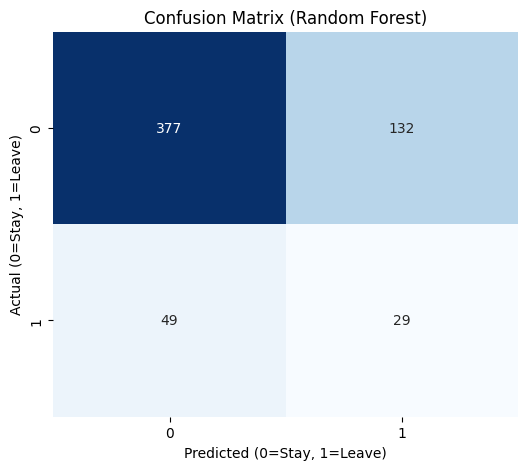

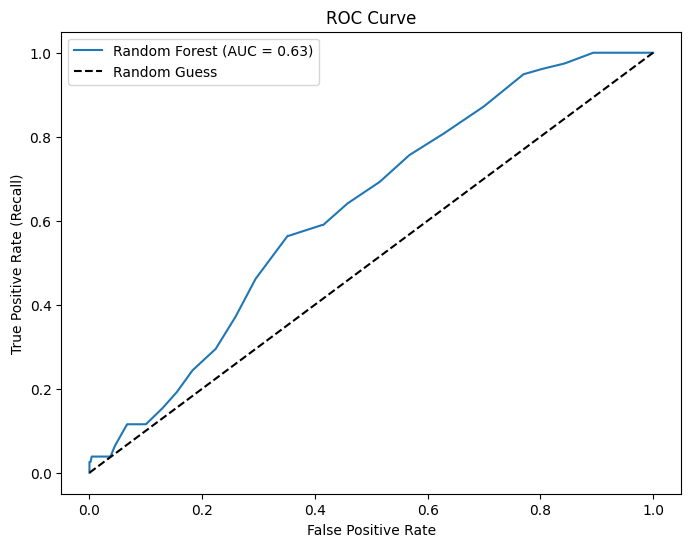

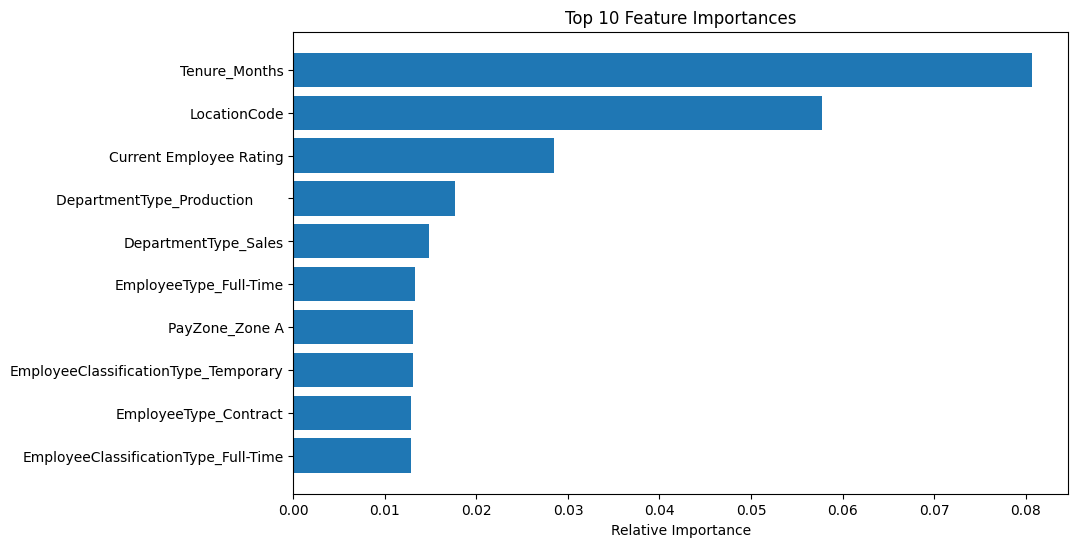

In [ ]:
# --- DEEP DIVE: BEST MODEL ---
# Automatically select best model based on F1-Score (best balance of Precision and Recall)
results_df = pd.DataFrame(results).T.drop(columns=['Model'])
best_model_name = results_df.sort_values('F1-Score', ascending=False).index[0]

print(f"Selected Best Model: {best_model_name}")
print(f"  F1-Score: {results_df.loc[best_model_name, 'F1-Score']:.4f}")
print(f"  Recall: {results_df.loc[best_model_name, 'Recall']:.4f}")
print(f"  Precision: {results_df.loc[best_model_name, 'Precision']:.4f}")
print(f"  AUC: {results_df.loc[best_model_name, 'AUC']:.4f}\n")

best_pipeline = results[best_model_name]['Model']

# Use optimal threshold (0.15) based on threshold tuning analysis
PREDICTION_THRESHOLD = 0.15
y_prob = best_pipeline.predict_proba(X_test)[:, 1]
y_pred = (y_prob > PREDICTION_THRESHOLD).astype(int)

# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Confusion Matrix ({best_model_name})')
plt.xlabel('Predicted (0=Stay, 1=Leave)')
plt.ylabel('Actual (0=Stay, 1=Leave)')
plt.show()

# 2. ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'{best_model_name} (AUC = {results[best_model_name]["AUC"]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve')
plt.legend()
plt.show()

# 3. Feature Importance
# We need to access the model inside the pipeline
model_step = best_pipeline.named_steps['classifier']
preprocessor_step = best_pipeline.named_steps['preprocessor']

# Get feature names from one-hot encoder
try:
    cat_features_encoded = preprocessor_step.transformers_[1][1]['onehot'].get_feature_names_out(categorical_features)
    all_features = numeric_features + list(cat_features_encoded)
    
    # Check if model is tree-based (has feature_importances_) or linear (has coef_)
    if hasattr(model_step, 'feature_importances_'):
        # Tree-based models (Random Forest, Gradient Boosting)
        importances = model_step.feature_importances_
        importance_type = 'Feature Importance'
    elif hasattr(model_step, 'coef_'):
        # Linear models (Logistic Regression)
        importances = np.abs(model_step.coef_[0])  # Use absolute value of coefficients
        importance_type = 'Coefficient Magnitude'
    else:
        raise AttributeError("Model doesn't support feature importance extraction")
    
    indices = np.argsort(importances)[-10:]  # Top 10

    plt.figure(figsize=(10, 6))
    plt.title(f'Top 10 {importance_type} ({best_model_name})')
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), [all_features[i] for i in indices])
    plt.xlabel(importance_type)
    plt.show()
    
    # Print top features
    print(f"\nTop 10 Features ({importance_type}):")
    top_features_df = pd.DataFrame({
        'Feature': [all_features[i] for i in indices],
        importance_type: importances[indices]
    }).sort_values(importance_type, ascending=False)
    print(top_features_df.to_string(index=False))
    
except Exception as e:
    print(f"Could not extract feature importance: {e}")